# Bank Churn Neural Network Model

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc

from imblearn.over_sampling import SMOTE

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

## Data Preprocessing

In [152]:
df = pd.read_csv('../content/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [154]:
df.duplicated().sum()

np.int64(0)

In [155]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [156]:
df[(df['Exited'] != 0)&(df['Exited']!=1)]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [157]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Thus, this is an unbalanced dataset. Next, I will drop unrelated features

### Split Data

In [158]:
X = df.drop(columns = ['Surname', 'Exited', 'CustomerId', 'RowNumber'])
y = df['Exited']

X_encoded = pd.get_dummies(X, drop_first=True, dtype=float)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42, stratify = y)

### Scaling

In [159]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Data Prediction

In [160]:
features = torch.tensor(X_train_scaled).float()
target = torch.tensor(y_train.to_numpy()).float()

dataset = TensorDataset(features, target)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle = True)

In [161]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()

        # Define layers
        self.layer1 = nn.Linear(input_dim, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, 10)
        self.layer4 = nn.Linear(10, 10)
        self.layer5 = nn.Linear(10, 10)
        self.layer6 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2) 
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Pass the input through each layer with ReLU activation
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x = torch.relu(self.layer6(x))
        
        # Pass through output layer and apply sigmoid activation
        x = self.sigmoid(self.output(x))
        return x
    
input_dim = X_train.shape[1]
model = NeuralNetwork(input_dim)

In [162]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [163]:
# Early stopping parameters
patience = 5 # Number of epochs to wait before stopping
min_val_loss = float('inf') # Initialize with a very high value
count = 0 # Tracks how many epochs the val_loss hasn't improved
best_model_state = None

# epoch
num_epochs = 50
train_loss = []
val_loss = []

In [164]:
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0

    for data in train_loader:
        # Set the gradients to zero
        optimizer.zero_grad()
        feature, target = data
        pred = model(feature)
        
        loss = criterion(pred, target.long())
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    epoch_train_loss = training_loss / len(train_loader)
    train_loss.append(epoch_train_loss)

    # Validation Phase
    model.eval()
    validation_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            feature, target = data
            pred = model(feature)

            loss = criterion(pred, target.long())
            validation_loss += loss.item()

    epoch_val_loss = validation_loss / len(val_loader)
    val_loss.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping check
    if epoch_val_loss < min_val_loss:
      min_val_loss = epoch_val_loss
      count = 0

      # Store the best model so the model will not keep the last-trained weights instead of the best-performing ones
      best_model_state = model.state_dict()
    else:
      count += 1
      if count >= patience:
        epoch = epoch + 1 # assign variable for plotting
        print(print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {min_val_loss:.4f}"))
        break

model.train()

Epoch 1/50 - Train Loss: 0.7121, Val Loss: 0.7013
Epoch 2/50 - Train Loss: 0.6808, Val Loss: 0.6245
Epoch 3/50 - Train Loss: 0.5420, Val Loss: 0.5006
Epoch 4/50 - Train Loss: 0.5131, Val Loss: 0.4974
Epoch 5/50 - Train Loss: 0.5101, Val Loss: 0.4929
Epoch 6/50 - Train Loss: 0.5071, Val Loss: 0.4911
Epoch 7/50 - Train Loss: 0.5042, Val Loss: 0.4882
Epoch 8/50 - Train Loss: 0.5014, Val Loss: 0.4857
Epoch 9/50 - Train Loss: 0.4988, Val Loss: 0.4836
Epoch 10/50 - Train Loss: 0.4968, Val Loss: 0.4815
Epoch 11/50 - Train Loss: 0.4950, Val Loss: 0.4797
Epoch 12/50 - Train Loss: 0.4936, Val Loss: 0.4782
Epoch 13/50 - Train Loss: 0.4918, Val Loss: 0.4767
Epoch 14/50 - Train Loss: 0.4901, Val Loss: 0.4750
Epoch 15/50 - Train Loss: 0.4882, Val Loss: 0.4729
Epoch 16/50 - Train Loss: 0.4862, Val Loss: 0.4705
Epoch 17/50 - Train Loss: 0.4843, Val Loss: 0.4679
Epoch 18/50 - Train Loss: 0.4829, Val Loss: 0.4665
Epoch 19/50 - Train Loss: 0.4817, Val Loss: 0.4661
Epoch 20/50 - Train Loss: 0.4805, Val Lo

NeuralNetwork(
  (layer1): Linear(in_features=11, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=10, bias=True)
  (layer4): Linear(in_features=10, out_features=10, bias=True)
  (layer5): Linear(in_features=10, out_features=10, bias=True)
  (layer6): Linear(in_features=10, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

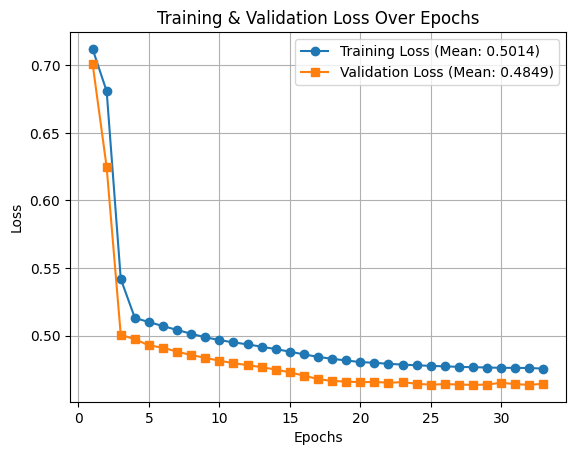

In [165]:
mean_train_loss = sum(train_loss) / len(train_loss)
mean_val_loss = sum(val_loss) / len(val_loss)

# Plot the Loss Curve
if num_epochs > epoch:
    range_epoch = epoch
else: range_epoch = num_epochs

plt.plot(range(1, range_epoch + 1), train_loss, label=f'Training Loss (Mean: {mean_train_loss:.4f})', marker='o')
plt.plot(range(1, range_epoch + 1), val_loss, label=f'Validation Loss (Mean: {mean_val_loss:.4f})', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [166]:
if best_model_state:
    model.load_state_dict(best_model_state)

In [167]:
features_test = torch.tensor(X_test_scaled).float()
target_test = torch.tensor(y_test.to_numpy()).float()

test_dataset = TensorDataset(features_test, target_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [168]:
model.eval()

testing_loss = 0.0
correct = 0
total = 0
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for data in test_loader:
        feature, target = data
        pred = model(feature)

        loss = criterion(pred, target.long())
        testing_loss += loss.item()

        # Compute for Confusion Matrix and Classification report
        _, predicted = torch.max(pred, 1) # Get class with highest probability
        correct += (predicted == target).sum().item()
        total += target.size(0)

        # Store results for Confusion Matrix
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

        # Store probabilities for Precision-Recall Curve
        probs = torch.softmax(pred, dim=1)  # Get probabilities
        probs = probs[:, 1]  # use the positive class
        all_probs.extend(probs.cpu().numpy())

average_test_loss = testing_loss / len(test_loader)
print(f'Testing Loss: {average_test_loss:.4f}')

Testing Loss: 0.4763


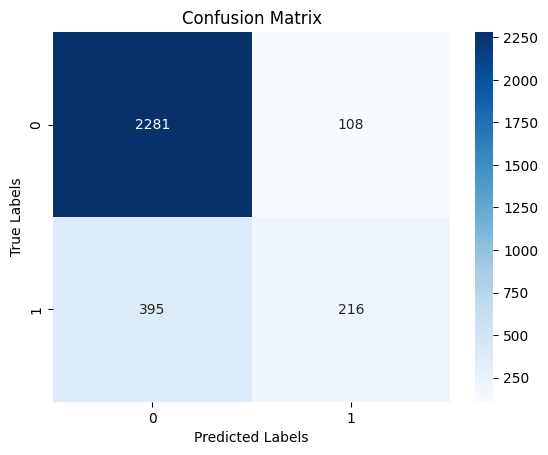

In [169]:
conf_matrix = confusion_matrix(all_targets, all_preds)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [170]:
class_report = classification_report(all_targets, all_preds)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90      2389
         1.0       0.67      0.35      0.46       611

    accuracy                           0.83      3000
   macro avg       0.76      0.65      0.68      3000
weighted avg       0.81      0.83      0.81      3000



In [171]:
precision, recall, thresholds = precision_recall_curve(all_targets, all_probs)
pr_auc = auc(recall, precision)
print(f'Area Under the Precision-Recall Curve (PR AUC): {pr_auc:.4f}')

Area Under the Precision-Recall Curve (PR AUC): 0.5440


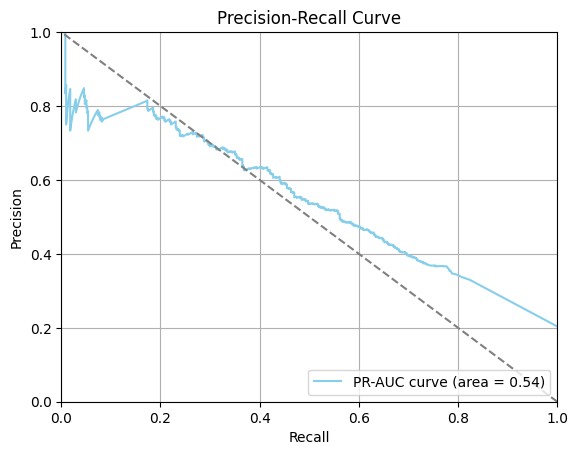

In [172]:
plt.plot(recall, precision, color = 'skyblue', label='PR-AUC curve (area = {:.2f})'.format(pr_auc))
plt.plot([1, 0], [0, 1], color='gray', linestyle='--') # random classifier line
plt.xlim([0.0, 1.0]) # set the limits of the x-axis
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()